### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**:

***DeadLine - 28.05.2024 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [16]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
filterwarnings("ignore")

In [17]:
x = load_npz("x.npz")
y = np.load("y.npy")
y[y == -1] = 0

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 666 для воспроизводимости).

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=666
)

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=666
)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [19]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

ESTIMATOR 1: Validation score: 0.8331606099081478
ESTIMATOR 2: Validation score: 0.873591999054406
ESTIMATOR 3: Validation score: 0.9214180860109278
ESTIMATOR 4: Validation score: 0.9260114615147045
ESTIMATOR 5: Validation score: 0.9286701821412365
ESTIMATOR 6: Validation score: 0.9328548170008655
ESTIMATOR 7: Validation score: 0.9342240219011777
ESTIMATOR 8: Validation score: 0.9344722403333982
ESTIMATOR 9: Validation score: 0.9400703094914001
ESTIMATOR 10: Validation score: 0.9450156137400912


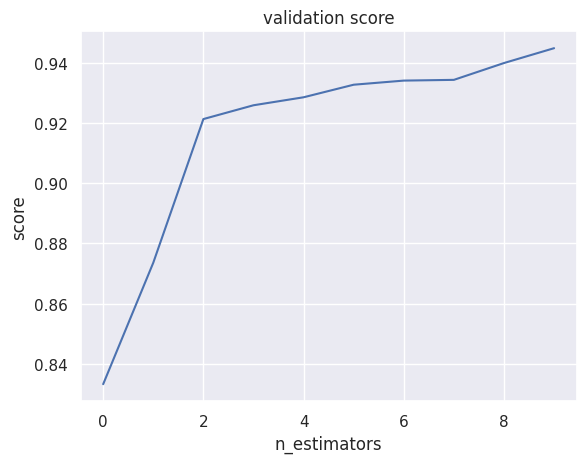

CPU times: user 844 ms, sys: 12 µs, total: 844 ms
Wall time: 842 ms
Train ROC-AUC 0.9859
Valid ROC-AUC 0.9450
Test ROC-AUC 0.9490


In [27]:
boosting = Boosting(plot=True)

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

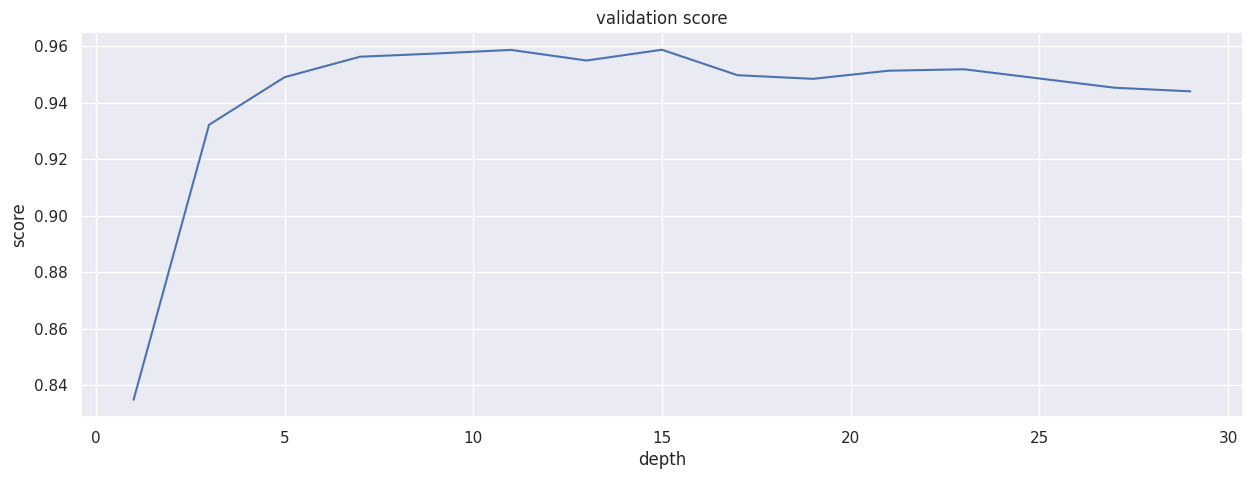

In [28]:
from matplotlib import pyplot as plt

results = {}

depths = range(1, 30, 2)

for depth in depths:
    boosting = Boosting(plot=False, base_model_params={"max_depth": depth})
    boosting.fit(x_train, y_train, x_valid, y_valid)
    results[depth] = boosting.score(x_valid, y_valid)

plt.figure(figsize=(15,5))
plt.plot(range(1, 30, 2), results.values())
plt.title('validation score')
plt.xlabel('depth')
plt.ylabel('score')
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Самое больше качество показал бустинг с максимальной глубиной дерева 7, так как глубина достаточно маленькая чтобы не переобучаться

## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

In [29]:
import optuna

# 1. Define an objective function to be maximized.
def objective(trial):
    
    boosting = Boosting(
        plot=False,
        n_estimators=trial.suggest_int(f'n_estimators', 10, 100, step=10),
        learning_rate=trial.suggest_float(f'learning_rate', 0.01, 1, step=0.05),
        subsample=trial.suggest_float(f'subsample', 0.3, 0.7, step=0.1),
        base_model_params={
            "max_depth": trial.suggest_int(f'max_depth', 3, 15, step=2),
            "min_samples_split":trial.suggest_int(f'min_samples_split', 3, 30, step=2),
            "min_samples_leaf": trial.suggest_int(f'min_samples_leaf', 3, 30, step=2)
        }
    )
    boosting.fit(x_train, y_train, x_valid, y_valid)
    return boosting.score(x_valid, y_valid)

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-05-24 22:50:10,891] A new study created in memory with name: no-name-6fceeff3-f322-4a4c-9af0-ae60914c856d
[I 2024-05-24 22:50:12,338] Trial 0 finished with value: 0.956241492513412 and parameters: {'n_estimators': 20, 'learning_rate': 0.21000000000000002, 'subsample': 0.6000000000000001, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 23}. Best is trial 0 with value: 0.956241492513412.
[I 2024-05-24 22:50:18,738] Trial 1 finished with value: 0.9606331667105147 and parameters: {'n_estimators': 50, 'learning_rate': 0.01, 'subsample': 0.5, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.9606331667105147.
[I 2024-05-24 22:50:26,673] Trial 2 finished with value: 0.9338835317936927 and parameters: {'n_estimators': 90, 'learning_rate': 0.81, 'subsample': 0.5, 'max_depth': 3, 'min_samples_split': 23, 'min_samples_leaf': 13}. Best is trial 1 with value: 0.9606331667105147.
[I 2024-05-24 22:50:28,445] Trial 3 finished with value

In [30]:
study.best_params

{'n_estimators': 60,
 'learning_rate': 0.81,
 'subsample': 0.5,
 'max_depth': 13,
 'min_samples_split': 25,
 'min_samples_leaf': 9}

## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

In [128]:
boosting = Boosting(
    plot=False,
    n_estimators=60,
    learning_rate=0.81,
    subsample=0.5
,
    base_model_params={
        "max_depth": 13,
        "min_samples_split": 25,
        "min_samples_leaf": 9
    }
)
boosting.fit(x_train, y_train, x_valid, y_valid)

In [140]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve


log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(x_train, y_train)
y_prob = log_reg.predict_proba(x_test)[:, 1]

In [130]:
boosting.predict_proba(x_test)[:, 1]

array([0.99999463, 0.98488501, 0.75616014, ..., 0.98015384, 0.99998981,
       0.90874615])

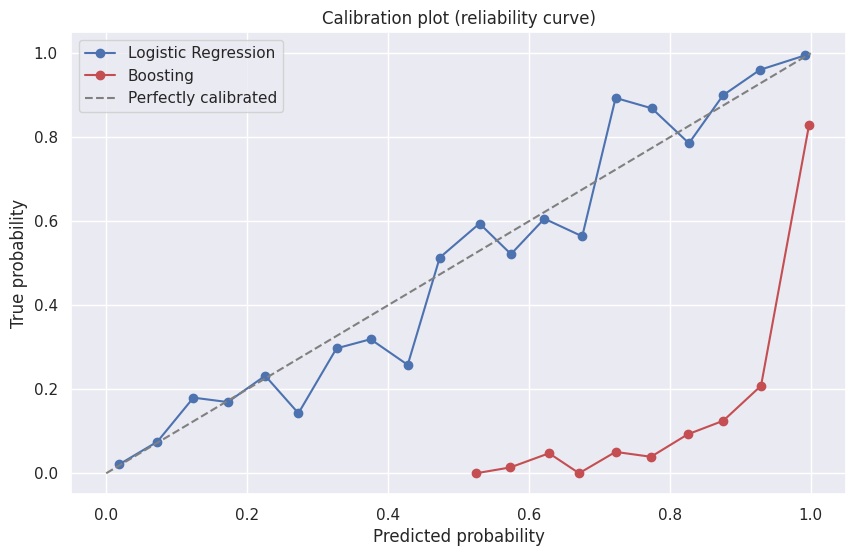

In [131]:
# Вычисление калибровочной кривой
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=20)
prob_true_boosting, prob_pred_boosting = calibration_curve(y_test, boosting.predict_proba(x_test)[:, 1], n_bins=20)

# Построение калибровочной кривой
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression', color='b')
plt.plot(prob_pred_boosting, prob_true_boosting, marker='o', label='Boosting', color='r')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration plot (reliability curve)')
plt.legend()
plt.show()

Бустинг очень плохо оценивает вероятности

Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

Text(0.5, 1.0, 'Линейная регрессия')

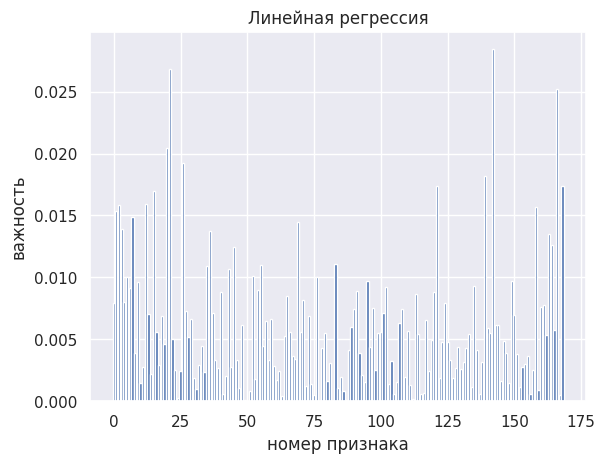

In [132]:
plt.bar(range(len(log_reg.coef_[0])), abs(log_reg.coef_[0]) / sum(abs(log_reg.coef_[0])),)
plt.xlabel('номер признака')
plt.ylabel('важность')
plt.title('Линейная регрессия')

Text(0.5, 1.0, 'boosting')

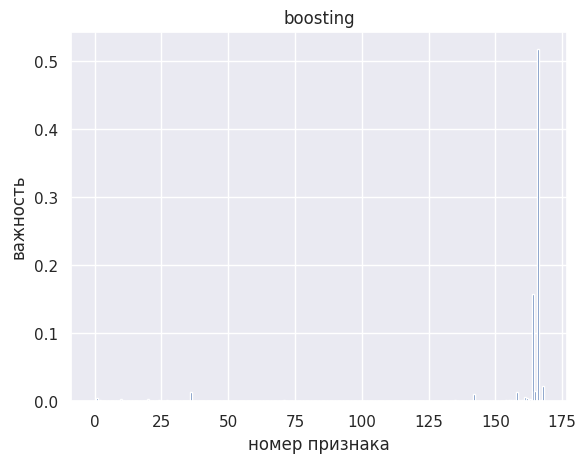

In [133]:
plt.bar(range(len(boosting.feature_importances_)), abs(boosting.feature_importances_))
plt.xlabel('номер признака')
plt.ylabel('важность')
plt.title('boosting')

Бустинг использует несколько основных признаков. В то время как логистическая регрессия использует признаки более равномерно

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

In [134]:
log_reg_coefs = log_reg.coef_[0]
boosting_reg_coefs = boosting.feature_importances_

In [135]:
scores = {
    'boosting_features':[],
    'log_reg_features':[]
}

for i in range(5, 100, 10):
    log_reg_features_idx = np.argpartition(abs(log_reg_coefs), -i)[-i:]
    boosting_features_idx = np.argpartition(abs(boosting_reg_coefs), -i)[-i:]
    boosting = Boosting(
        plot=False,
        n_estimators=60,
        learning_rate=0.81,
        subsample=0.5
    ,
        base_model_params={
            "max_depth": 13,
            "min_samples_split": 25,
            "min_samples_leaf": 9
        }
    )
    boosting.fit(x_train[:, log_reg_features_idx], y_train, x_valid[:, log_reg_features_idx], y_valid)
    # print(f'Признаки логистической регрессии {boosting.score(x_test[:, log_reg_features_idx], y_test)}')
    scores['log_reg_features'].append(boosting.score(x_test[:, log_reg_features_idx], y_test))
    boosting = Boosting(
        plot=False,
        n_estimators=60,
        learning_rate=0.81,
        subsample=0.5
    ,
        base_model_params={
            "max_depth": 13,
            "min_samples_split": 25,
            "min_samples_leaf": 9
        }
    )
    boosting.fit(x_train[:, boosting_features_idx], y_train, x_valid[:, boosting_features_idx], y_valid)
    scores['boosting_features'].append(boosting.score(x_test[:, log_reg_features_idx], y_test))
    # print(f'Признаки boosting регрессии {boosting.score(x_test[:, boosting_features_idx], y_test)}')

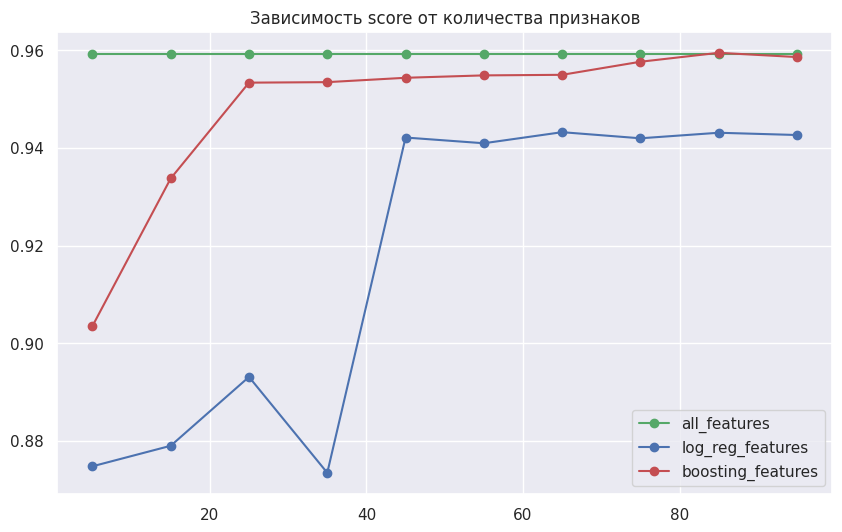

In [136]:
boosting = Boosting(
    plot=False,
    n_estimators=60,
    learning_rate=0.81,
    subsample=0.5
,
    base_model_params={
        "max_depth": 13,
        "min_samples_split": 25,
        "min_samples_leaf": 9
    }
)
boosting.fit(x_train, y_train, x_valid, y_valid)
all_features = boosting.score(x_test, y_test)



plt.figure(figsize=(10, 6))
plt.plot(range(5, 100, 10), [all_features for _ in range(len(scores['boosting_features']))], marker='o', label='all_features', color='g')
plt.plot(range(5, 100, 10), scores['boosting_features'], marker='o', label='log_reg_features', color='b')
plt.plot(range(5, 100, 10), scores['log_reg_features'], marker='o', label='boosting_features', color='r')
plt.title('Зависимость score от количества признаков')
plt.legend()
plt.show()

Чуть чуть улучшилось качество в районе 70 признаков

## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [143]:
meta_feature_logreg = log_reg.predict_proba(x_train)
meta_feature_boosting = boosting.predict_proba(x_train)
x_meta_train = np.append(meta_feature_logreg, meta_feature_boosting, axis=1)
x_meta_train.shape, y_train.shape

((18825, 4), (18825,))

In [149]:
log_reg1 = LogisticRegression(max_iter=1000)
log_reg1.fit(x_meta_train, y_train)

meta_feature_logreg = log_reg.predict_proba(x_test)
meta_feature_boosting = boosting.predict_proba(x_test)
x_meta_test = np.append(meta_feature_logreg, meta_feature_boosting, axis=1)

from sklearn.metrics import roc_auc_score
print("Только логистическая регрессия", roc_auc_score(y_test == 1, meta_feature_logreg[:, 1]))
print("Только бустинг", roc_auc_score(y_test == 1, meta_feature_boosting[:, 1]))
print("Только блендинг", roc_auc_score(y_test == 1, log_reg1.predict_proba(x_meta_test)[:, 1]))

Только логистическая регрессия 0.9622659681329824
Только бустинг 0.959121133827783
Только блендинг 0.9637512277668733


Качество чуточку улучшилось на 0.002

## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [162]:
import numpy as np

from catboost import CatBoostClassifier, Pool


test_data = catboost_pool = Pool(x_train, y_train)

model = CatBoostClassifier(iterations=100,
                           depth=13,
                           learning_rate=0.81,
                           loss_function='Logloss',
                           verbose=True)

model.fit(x_train, y_train)

0:	learn: 0.3010889	total: 47.7ms	remaining: 4.73s
1:	learn: 0.2465184	total: 94ms	remaining: 4.61s
2:	learn: 0.2260167	total: 137ms	remaining: 4.42s
3:	learn: 0.2183341	total: 193ms	remaining: 4.64s
4:	learn: 0.2080660	total: 257ms	remaining: 4.89s
5:	learn: 0.1993199	total: 307ms	remaining: 4.8s
6:	learn: 0.1950099	total: 361ms	remaining: 4.8s
7:	learn: 0.1906523	total: 409ms	remaining: 4.71s
8:	learn: 0.1869828	total: 453ms	remaining: 4.58s
9:	learn: 0.1794260	total: 516ms	remaining: 4.64s
10:	learn: 0.1761964	total: 566ms	remaining: 4.58s
11:	learn: 0.1731691	total: 639ms	remaining: 4.68s
12:	learn: 0.1682769	total: 700ms	remaining: 4.68s
13:	learn: 0.1656953	total: 749ms	remaining: 4.6s
14:	learn: 0.1609786	total: 796ms	remaining: 4.51s
15:	learn: 0.1575129	total: 840ms	remaining: 4.41s
16:	learn: 0.1551062	total: 891ms	remaining: 4.35s
17:	learn: 0.1524150	total: 931ms	remaining: 4.24s
18:	learn: 0.1492255	total: 977ms	remaining: 4.16s
19:	learn: 0.1453697	total: 1.03s	remaining:

In [163]:
print("catboost", roc_auc_score(y_test == 1, model.predict_proba(x_test)[:, 1]))

catboost 0.9567722585975521


Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)
